In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize as opt
import sklearn.linear_model
import sklearn.model_selection
import pandas as pd
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.datasets import fetch_20newsgroups
from sklearn.metrics import f1_score, make_scorer

In [2]:
from sklearn.linear_model import RidgeClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

Loading dataset. The dataset contains some trash information such as headers, footers and quotes, that can bring classifiers to overfitting on metadata. Thus we remove them.

In [3]:
remove=('headers', 'footers', 'quotes')

data_train = fetch_20newsgroups(subset='train', shuffle=True, random_state=42,
                                remove=remove)

data_test = fetch_20newsgroups(subset='test', shuffle=True, random_state=42,
                               remove=remove)

In [4]:
target_names = data_train.target_names
y_train, y_test = data_train.target, data_test.target

Usign HashingVectorizer as it was suggested.

In [5]:
vectorizer = HashingVectorizer(stop_words='english', alternate_sign=False) #Using english stop words to clean data
X_train = vectorizer.transform(data_train.data)
X_train.shape

(11314, 1048576)

In [6]:
X_test = vectorizer.transform(data_test.data)
X_test.shape

(7532, 1048576)

Defining functions to test different models with default params.



In [7]:
def benchmark(clf):
    print('_' * 80)
    print("Training: ")
    print(clf)
    clf.fit(X_train, y_train)
    pred = clf.predict(X_test)
    score = f1_score(y_test, pred, average='weighted')
    print("accuracy:   %0.3f" % score)
    clf_descr = str(clf).split('(')[0]
    return clf_descr, score

In [8]:
def try_models():
  results = []
  for clf, name in (
          (RidgeClassifier(tol=1e-2, solver="auto"), "Ridge Classifier"), #Trying some default classification models with default params
          (Perceptron(tol=1e-2), "Perceptron"),
          (PassiveAggressiveClassifier(), "Passive-Aggressive"),
          (KNeighborsClassifier(n_neighbors=10), "kNN"),
          (RandomForestClassifier(n_estimators=20), "Random forest")):
      print('=' * 80)
      print(name)
      results.append(benchmark(clf))

  for penalty in ["l2", "l1"]:
      print('=' * 80)
      print("%s penalty" % penalty.upper())
      # Train Liblinear model
      results.append(benchmark(LinearSVC(penalty=penalty, dual=False,
                                        tol=1e-3))) #Trying penalty to regularize models

      # Train SGD model
      results.append(benchmark(SGDClassifier(alpha=.0001,
                                            penalty=penalty)))

  # Train SGD with Elastic Net penalty
  print('=' * 80)
  print("Elastic-Net penalty")
  results.append(benchmark(SGDClassifier(alpha=.0001,
                                        penalty="elasticnet")))

  # Train NearestCentroid without threshold
  print('=' * 80)
  print("NearestCentroid (aka Rocchio classifier)")
  results.append(benchmark(NearestCentroid()))

  # Train sparse Naive Bayes classifiers
  print('=' * 80)
  print("Naive Bayes")
  results.append(benchmark(MultinomialNB(alpha=.01)))
  results.append(benchmark(BernoulliNB(alpha=.01)))

  # make some plots

  indices = np.arange(len(results))

  results = [[x[i] for x in results] for i in range(2)]

  clf_names, score = results

  plt.figure(figsize=(12, 8))
  plt.title("Score")
  plt.barh(indices, score, .2, label="score", color='navy')
  plt.yticks(())
  plt.legend(loc='best')
  plt.subplots_adjust(left=.25)
  plt.subplots_adjust(top=.95)
  plt.subplots_adjust(bottom=.05)

  for i, c in zip(indices, clf_names):
      plt.text(-.3, i, c)

  plt.show()

With this kind of problem the best metric to measure our models would be F1 score. The F1-score combines the precision and recall of a classifier into a single metric by taking their harmonic mean. It is primarily used to compare the performance of two classifiers. Suppose that classifier A has a higher recall, and classifier B has higher precision. In this case, the F1-scores for both the classifiers can be used to determine which one produces better results.

Ridge Classifier
________________________________________________________________________________
Training: 
RidgeClassifier(tol=0.01)
accuracy:   0.682
Perceptron
________________________________________________________________________________
Training: 
Perceptron(tol=0.01)
accuracy:   0.609
Passive-Aggressive
________________________________________________________________________________
Training: 
PassiveAggressiveClassifier()
accuracy:   0.642
kNN
________________________________________________________________________________
Training: 
KNeighborsClassifier(n_neighbors=10)
accuracy:   0.068
Random forest
________________________________________________________________________________
Training: 
RandomForestClassifier(n_estimators=20)
accuracy:   0.541
L2 penalty
________________________________________________________________________________
Training: 
LinearSVC(dual=False, tol=0.001)
accuracy:   0.667
_____________________________________________________________________________

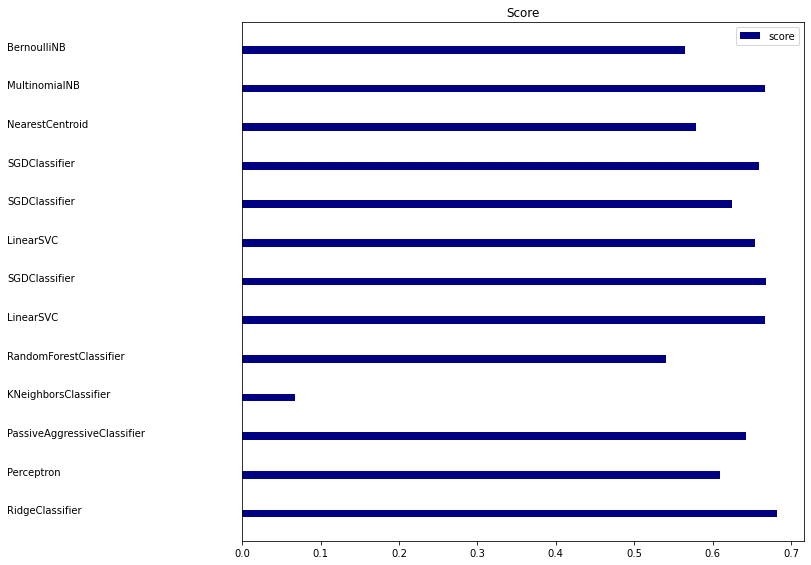

In [9]:
try_models()#With HashVectorizer

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer # Trying different vectorizer that accounts originality of words
vectorizer = TfidfVectorizer(sublinear_tf=True, stop_words='english')
X_train = vectorizer.fit_transform(data_train.data)
X_test = vectorizer.transform(data_test.data)
X_test.shape

(7532, 101322)

Ridge Classifier
________________________________________________________________________________
Training: 
RidgeClassifier(tol=0.01)
accuracy:   0.701
Perceptron
________________________________________________________________________________
Training: 
Perceptron(tol=0.01)
accuracy:   0.630
Passive-Aggressive
________________________________________________________________________________
Training: 
PassiveAggressiveClassifier()
accuracy:   0.685
kNN
________________________________________________________________________________
Training: 
KNeighborsClassifier(n_neighbors=10)
accuracy:   0.058
Random forest
________________________________________________________________________________
Training: 
RandomForestClassifier(n_estimators=20)
accuracy:   0.569
L2 penalty
________________________________________________________________________________
Training: 
LinearSVC(dual=False, tol=0.001)
accuracy:   0.695
_____________________________________________________________________________

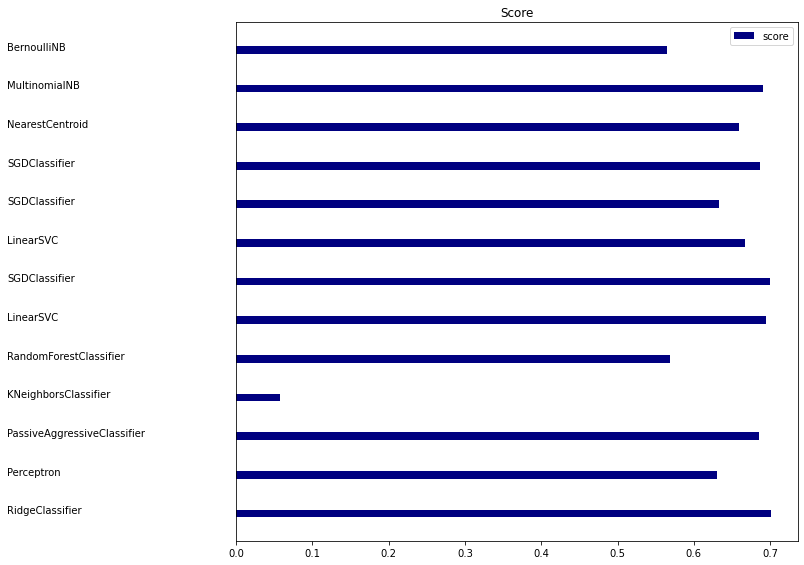

In [11]:
try_models() #Triyng with TfidVectorizer

We can see that the RidgeClassifier gives the best f1 score on TfidVectorizer. Thus we can use gridsearch to find best hyperparams

In [12]:
tol = [0.5, 0.3, 0.1, 1e-2, 1e-3]
alpha = [3, 1, 0.5, 1e-2, 1e-3]
param_grid = dict(tol = tol, alpha = alpha)
grid = GridSearchCV(RidgeClassifier(), param_grid, cv=10, scoring='f1_weighted')

In [ ]:
grid.fit(X_train, y_train)

In [ ]:
print(grid.best_score_)
print(grid.best_params_)
print(grid.best_estimator_)

In [ ]:
clf = RidgeClassifier(alpha=1, tol=0.01)
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
score = f1_score(y_test, pred, average='weighted')
print("accuracy:   %0.3f" % score)